# Kernel Scan - Quick Start Example

This notebook demonstrates the kernel_scan library's API as shown in the README's Quick Start section.

In [1]:
import logging
import sys
from pathlib import Path
import os
import polars as pl

## Add source directory to path

This is important for imports to work correctly when running in a notebook.

In [2]:
# Add the src directory to sys.path to import kernel_scan
# Get the parent directory of the notebook directory (project_root)
notebook_path = Path(os.getcwd())
project_root = notebook_path.parent.parent
src_path = project_root / "src"

# Add the src path to sys.path if it's not already there
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

print(f"Added {src_path} to Python path")

Added /home/anders/projects/kernel_scan/src to Python path


## Import kernel_scan modules

Now we can import the necessary modules from kernel_scan.

In [3]:
try:
    # Import kernel_scan modules
    from kernel_scan import (
        DataType,
        EngineType,
        KernelSpec,
        Layout,
        OperationType,
        Profiler,
    )
    from kernel_scan.core.types import TensorSpec
    from kernel_scan.ops import GemmParams
    
    print("Successfully imported kernel_scan modules")
except ImportError as e:
    log.error(f"Error importing kernel_scan: {e}")
    log.error(
        "Make sure the kernel_scan package is properly installed or in the Python path."
    )

Successfully imported kernel_scan modules


## Create a GEMM kernel specification

First, we'll create a kernel specification for a General Matrix Multiplication (GEMM) operation.

In [4]:
# Create output directories if they don't exist
results_dir = project_root / "results"
plots_dir = project_root / "plots"

results_dir.mkdir(exist_ok=True)
plots_dir.mkdir(exist_ok=True)

In [5]:
# Create a GEMM kernel specification
kernel_spec = (
    KernelSpec.builder()
    .operation_type(OperationType.GEMM)
    .data_type(DataType.FLOAT32)
    .operation_params(
        GemmParams(
            m=1024,
            n=1024,
            k=1024,
            alpha=1.0,
            beta=0.0,
            layout_a=Layout.ROW_MAJOR,
            layout_b=Layout.ROW_MAJOR,
            layout_c=Layout.ROW_MAJOR,
        )
    )
    .inputs(
        a=TensorSpec.create_2d(1024, 1024, Layout.ROW_MAJOR, DataType.FLOAT32),
        b=TensorSpec.create_2d(1024, 1024, Layout.ROW_MAJOR, DataType.FLOAT32),
    )
    .outputs(c=TensorSpec.create_2d(1024, 1024, Layout.ROW_MAJOR, DataType.FLOAT32))
    .iterations(10)  # Reduced for quick example
    .build()
)

## Initialize Profiler and Run Profiling

Now we'll initialize the profiler and run the profiling with the ComposableKernel engine.

In [6]:
profiler = Profiler()
result_set = profiler.profile_with_engine(
    kernel_spec,
    EngineType.COMPOSABLE_KERNEL,
    warmup_iterations=2,
    output_file=str(results_dir / "quickstart_notebook.jsonl"),
)
print(f"Profiling complete. Results saved to {results_dir / 'quickstart_notebook.jsonl'}")


Profiling complete. Results saved to /home/anders/projects/kernel_scan/results/quickstart_notebook.jsonl


## Visualize Results with Roofline Plot

Now we'll visualize the profiling results using a roofline plot.

In [7]:
# Add debug to see what's in the results
print(f"Result set contains {len(result_set.results)} results")
print(f"Accelerator: {result_set.accelerator_specs.name}")
print(f"Peak compute: {result_set.accelerator_specs.get_peak_compute(DataType.FLOAT32)} TFLOPS")
print(f"Peak bandwidth: {result_set.accelerator_specs.peak_bandwidth} GB/s")

Result set contains 25 results
Accelerator: Radeon RX 7900 XTX
Peak compute: 61.4 TFLOPS
Peak bandwidth: 960.0 GB/s


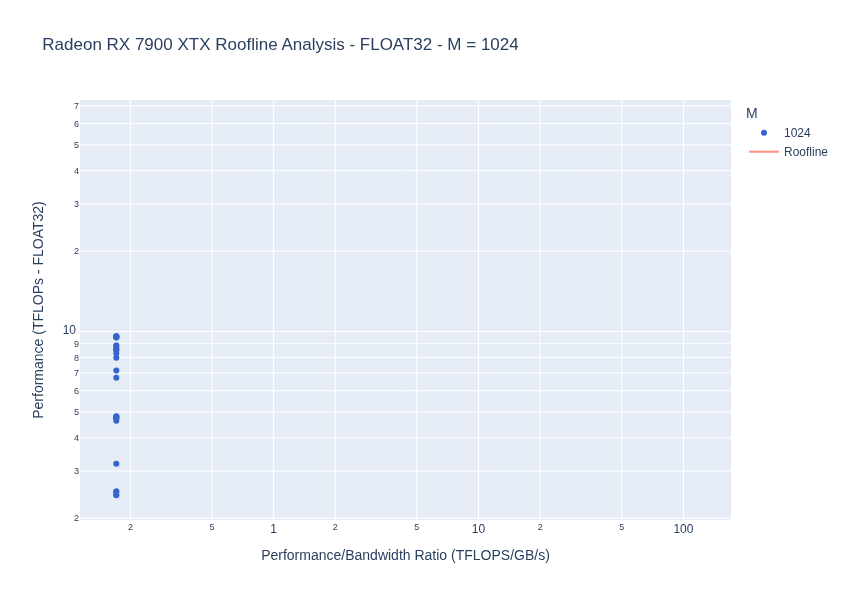

In [8]:
# Generate roofline plots

for group, fig in figures.items():
    fig.show()

## Conclusion

This notebook has demonstrated:
1. Setting up a GEMM kernel specification
2. Profiling the kernel using the ComposableKernel engine
3. Visualizing the results with roofline plots
4. Improving the visualization with square root scaling for point sizes

The square root scaling of the time_ms values for point sizes helps to make the visualization more effective, as extremely large or small execution times can distort the scatter plot.